<a href="https://colab.research.google.com/github/yungchidanielcho/Pipeline_Corrosion_CNN/blob/main/Pipeline_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import os
#from skimage import io
from PIL import Image 
from torch.utils.data import Dataset
import glob
import torch
import pandas as pd


# Reference: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwinyoaFucPuAhWNTN8KHcslBfQQwqsBMAJ6BAgHEAM&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DZoZHd0Zm3RY&usg=AOvVaw1C-mkR5l5xMVuytCCMYZ2e
class CustomDataset(Dataset):
    # build wrapper for the class dataset
    # images are uploaded to google drives
    # Sizes of the images varies. The images are potraits or landscape. Most are 3-channels, at least 1 is 4-channels.

    #Paths
    classification_str ='pipeline'
    root_dir = '/content/drive/MyDrive/Pipeline Classification/'
    pipeline_path = '/content/drive/MyDrive/Pipeline Classification/Class_pipeline/*.*'
    pipeline_and_corrosion_path = '/content/drive/MyDrive/Pipeline Classification/Class_pipeline_corrosion/*.*'
    not_pipeline_path = '/content/drive/MyDrive/Pipeline Classification/Class_not_pipeline/*.*'
    corrosion_path = '/content/drive/MyDrive/Pipeline Classification/Class_corrosion/*.*'
    csv_path = '/content/drive/MyDrive/Pipeline Classification/class_' + classification_str + '.csv'

    def __init__(self,csv_path=csv_path, root_dir=root_dir, transform=None,classification_str=classification_str):
        self.annotations = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform
        self.classification = classification_str
      

    def build_csv(pipeline_path=pipeline_path, not_pipeline_path=not_pipeline_path, pipeline_and_corrosion_path=pipeline_and_corrosion_path, corrosion_path=corrosion_path, csv_path=csv_path):
        # build the csv file containing image path and class.
        # re-run if content of the folder changes
        # could have used images folder from torchvision
        
        path_and_class = {}
        #glob search for file names in a folder
        for file in glob.glob(pipeline_path): 
          path_and_class[file] = 1

        for file in glob.glob(pipeline_and_corrosion_path): 
          path_and_class[file] = 1

        for file in glob.glob(not_pipeline_path):
          path_and_class[file] = 0
        
        for file in glob.glob(corrosion_path):
          path_and_class[file] = 0

        #save csv and load it with pandas later
        with open(csv_path, 'w') as f: 
          for key in path_and_class.keys():
            f.write("%s,%s\n"% (key, path_and_class[key]))

    def __len__(self):
         return len(self.annotations)

    def __getitem__(self, index): 
        img_path = self.annotations.iloc[index, 0]
        #image = io.imread(img_path) won't work because it loads image to numpy array. PIL format is expcted
        image = Image.open(img_path).convert('RGB') # there was a 4-channel image at 15
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        # put a timer functions
        if self.transform:
            image = self.transform(image)
        return (image,y_label,index)


In [ ]:
CustomDataset.build_csv()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The label is 1
The index is 39
The dataset has 8039 images
There are 1068 images labeled 1 and 6971 images labeled 0


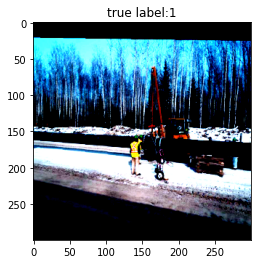

In [40]:
# Testing the CustomDataset dataset
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode
from PIL import ImageOps 
import numpy as np
size = (300,300) # resize to square
interpolation = InterpolationMode.BILINEAR
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return ImageOps.expand(image, padding)
        
transform = transforms.Compose(
                            # pad to square
                            [SquarePad(),
                             transforms.RandomRotation(degrees=(-1,1)),
                             transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                             transforms.RandomResizedCrop(size, scale=(0.5, 1.0), interpolation=interpolation),
                             transforms.RandomHorizontalFlip(p=0.1),
                             transforms.RandomPerspective(distortion_scale=0.1,p=0.1),
                             transforms.ToTensor(),
                             # Normalize using parameters from https://pytorch.org/docs/stable/torchvision/models.html
                             transforms.Normalize(mean=mean, std=std)])
                             # Always put random Erasing last because normalize can't functions without data.
                             #transforms.RandomErasing(p=0.1)])


#print(f'The label is {item[1]}')
def testItem(transform=transform, item_no=39):
    '''
    This function applies transformation and shows an image and its true label
    '''
    DS1 = CustomDataset(transform=transform)
    item = DS1.__getitem__(item_no)
    plt.title('true label:{}'.format(item[1]))
    plt.imshow( item[0].permute(1, 2, 0)  ) #look up how permute works!
    print(f'The label is {item[1]}')
    print(f'The index is {item[2]}')


def testCount():
    DS1 = CustomDataset()
    num_images = len(DS1.annotations)
    num_true_images = sum(DS1.annotations.iloc[:,1])
    num_false_images = num_images - num_true_images
    print(f'The dataset has {num_images} images')
    print(f'There are {num_true_images} images labeled 1 and {num_false_images} images labeled 0')

testItem()
testCount()


In [41]:
def SaveWrongPredictions(dataset, wrong_prediction):
    '''
    
    '''
    from matplotlib.backends.backend_pdf import PdfPages


    

    #https://matplotlib.org/stable/faq/howto_faq.html#save-multiple-plots-to-one-pdf-file

    pdf = PdfPages(os.path.join(trial_path,'Wrong ' + dataset.classification.title() + ' Classification Predictions.pdf'))

    for index, pred, true_label in zip(wrong_prediction['index'],
                                       wrong_prediction['pred'],
                                       wrong_prediction['true label']):
        img = dataset.__getitem__(int(index))[0]
        plt.figure()
        plt.title('true label:{0},prediction:{1}'.format(int(true_label), int(pred)))
        plt.imshow(img,interpolation='none')
        plt.savefig(pdf, format='pdf')
        plt.close()
    pdf.close()


In [42]:
# calculate and plot accuracy 
def check_model(loader, model,epoch, get_index_wrong_prediction = False):
    '''
    This function performs diagnostics on the model performance by building confusion matrix. The output is a row of data for a particular epoch, which can be appended into a larger table
    Inputs:
    loader is the dataloader of either training or test set
    model is the convolutional network
    epoch is the current number of epoch (int)
    get_Image_Wrong_prediction is a binary. If true, the images results in false positive and false negative wil be saved

    '''
    print(f'Checking epoch {epoch} performance')
    # set counters to zero
    num_true_positive = 0
    num_true_negative = 0
    num_false_positive = 0
    num_false_negative = 0
    num_samples = 0

    # create empty list to store wrong prediction result for analysis
    wrong_prediction = {'index':[],'pred':[],'true label':[]}

    # create empty list to store all prediction to show model effect
    all_prediction = {'index':[],'pred':[],'true label':[]}

    # create empty list for all predictions for ROC
    all_y = np.array([])
    all_prob = np.array([])
    

    model.eval() # drop_out and batch_norm behaves differently in training and eval

    with torch.no_grad(): # dont track intermediate and gradients, speed up calculation
        for x,y,index in loader: # x = B,C,H,W
        #x,y,index = next(iter(test_loader))
            x = x.to(device=device)
            y = y.to(device=device) # B, 1
            scores = model(x) # B, 1000s check with scores.size
            _, predictions = scores.max(1) # the first object is value, the second object is index, which is used as prediction
            #m = nn.LogSoftmax()
            #get a probability for ROC curve
            prob = scores.softmax(dim=1)[:,1]
            # set tensor masks.
            # predictions, y are tensors at size batch_size, except for the last batch
            accurate_prediction = (predictions == y)
            inaccurate_prediction = torch.logical_not(accurate_prediction)
            # create a tensor of ones with the same size as prediction to make comparison
            ones = torch.ones(predictions.size(), device = device)
            # create a tensor mask where predictions  == 1
            is_pipeline = (predictions == ones)
            not_pipeline = torch.logical_not(is_pipeline) # use &

            #zeros = torch.zeros(batch_size, device = device)

            # count confusion matrix 
            num_true_positive += torch.logical_and(accurate_prediction, is_pipeline).sum()
            num_true_negative += torch.logical_and(accurate_prediction, not_pipeline).sum()
            num_false_positive += torch.logical_and(inaccurate_prediction, is_pipeline).sum()
            num_false_negative += torch.logical_and(inaccurate_prediction, not_pipeline).sum()
            num_samples += predictions.size(0)

            #save all predictions
            all_prediction['index'].extend(index)
            all_prediction['pred'].extend(predictions)
            all_prediction['true label'].extend(y)


            # store index of wrong prediction
            if get_index_wrong_prediction:
                wrong_prediction['index'].extend(index[inaccurate_prediction])
                wrong_prediction['pred'].extend(predictions[inaccurate_prediction])
                wrong_prediction['true label'].extend(y[inaccurate_prediction])
                # get all probability for ROC curve
                # set the shape of containers to the shape of the data

                if all_y.size == 0:
                    all_y = y.cpu().numpy()
                    all_prob = prob.cpu().numpy()
                else:
                    #When there is only one column, use hstack, when there are two, use vstack
                    all_prob = np.hstack((all_prob,prob.cpu().numpy()))
                    all_y = np.hstack((all_y,y.cpu().numpy()))

            # calculate statistics  
            num_correct = num_true_positive + num_true_negative
            accuracy =  float(num_correct) / float(num_samples)
            precision = num_true_positive / (num_true_positive + num_false_positive)
            recall = num_true_positive / (num_true_positive + num_false_negative)
            specificity = num_true_negative / (num_true_negative + num_false_positive)
            false_positive_rate = 1 - specificity

            # store statistics in dataframe
            # if tensor only has one item, use item() to transfer value from cuda to cpu
            confusion_matrix = pd.DataFrame(data={'True Positive':num_true_positive.item(),
                                                    'True Negative':num_true_negative.item(),
                                                    'False Positive':num_false_positive.item(),
                                                    'False Negative':num_false_negative.item(), 
                                                    'Accuracy':accuracy, 'Precision':precision.item(),
                                                    'Recall':recall.item(),
                                                    'Specificity':specificity.item(),
                                                    'False Positive Rate':false_positive_rate.item()},index=[epoch])
        # print result for each batch    
        print(f'Got {num_correct} / {num_samples} with accuracy {accuracy}, precision {precision}, recall {recall}, Specificity {specificity}, False Positive Rate {false_positive_rate}.')

      
    model.train()
    return confusion_matrix, wrong_prediction, all_prob, all_y, all_prediction

#Plot ROC curves
def plot_ROC_curve(all_y_testing,prob_testing,epoch):
    fpr, tpr, thresholds = metrics.roc_curve(all_y_testing, prob_testing, pos_label=None, sample_weight=None, drop_intermediate=False)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='CNN')

    display.plot()  
    plt.title(dataset.classification.title() +' Classification ROC Curve for Test Set' + ' epoch ' + str(epoch)) 
    plt.savefig(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() +' Classification ROC Curve for Test Set'+ ' epoch ' + str(epoch) + '.png'))
    return 


working on epoch 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 0 is 0.23072477110492234
evaluating training set
Checking epoch 0 performance
Got 5413 / 5627 with accuracy 0.961969077661276, precision 0.8418972492218018, recall 0.8717598915100098, Specificity 0.9754801988601685, False Positive Rate 0.024519801139831543.
evaluating testing set
Checking epoch 0 performance
Got 2261 / 2412 with accuracy 0.9373963515754561, precision 0.7787878513336182, recall 0.7671641707420349, Specificity 0.9648531675338745, False Positive Rate 0.03514683246612549.
working on epoch 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 1 is 0.11996562880548564
evaluating training set
Checking epoch 1 performance
Got 5441 / 5627 with accuracy 0.9669450861915764, precision 0.8198830485343933, recall 0.9563437700271606, Specificity 0.968532919883728, False Positive Rate 0.03146708011627197.
evaluating testing set
Checking epoch 1 performance
Got 2242 / 2412 with accuracy 0.9295190713101161, precision 0.7057356834411621, recall 0.8447760939598083, Specificity 0.9431872963905334, False Positive Rate 0.05681270360946655.
working on epoch 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 2 is 0.07934346427844668
evaluating training set
Checking epoch 2 performance
Got 5554 / 5627 with accuracy 0.9870268349031456, precision 0.96875, recall 0.9304229021072388, Specificity 0.9955046772956848, False Positive Rate 0.0044953227043151855.
evaluating testing set
Checking epoch 2 performance
Got 2284 / 2412 with accuracy 0.9469320066334992, precision 0.8556700944900513, recall 0.7432835698127747, Specificity 0.979778528213501, False Positive Rate 0.020221471786499023.
working on epoch 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 3 is 0.052313661501764065
evaluating training set
Checking epoch 3 performance
Got 5569 / 5627 with accuracy 0.9896925537586636, precision 0.9856114983558655, recall 0.9345157146453857, Specificity 0.9979566931724548, False Positive Rate 0.002043306827545166.
evaluating testing set
Checking epoch 3 performance
Got 2287 / 2412 with accuracy 0.9481757877280266, precision 0.8947368264198303, recall 0.7104477882385254, Specificity 0.9865190386772156, False Positive Rate 0.013480961322784424.
working on epoch 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 4 is 0.04416068822187795
evaluating training set
Checking epoch 4 performance
Got 5585 / 5627 with accuracy 0.9925359872045495, precision 0.9687923789024353, recall 0.9740791320800781, Specificity 0.9953003525733948, False Positive Rate 0.004699647426605225.
evaluating testing set
Checking epoch 4 performance
Got 2284 / 2412 with accuracy 0.9469320066334992, precision 0.8438538312911987, recall 0.7582089304924011, Specificity 0.9773712158203125, False Positive Rate 0.0226287841796875.
working on epoch 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 5 is 0.035412676971067085
evaluating training set
Checking epoch 5 performance
Got 5593 / 5627 with accuracy 0.9939577039274925, precision 0.9807427525520325, recall 0.9727148413658142, Specificity 0.9971393346786499, False Positive Rate 0.0028606653213500977.
evaluating testing set
Checking epoch 5 performance
Got 2268 / 2412 with accuracy 0.9402985074626866, precision 0.7902735471725464, recall 0.7761194109916687, Specificity 0.9667789936065674, False Positive Rate 0.03322100639343262.
working on epoch 6


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 6 is 0.031201760623926846
evaluating training set
Checking epoch 6 performance
Got 5593 / 5627 with accuracy 0.9939577039274925, precision 0.9755101799964905, recall 0.9781718850135803, Specificity 0.9963220357894897, False Positive Rate 0.003677964210510254.
evaluating testing set
Checking epoch 6 performance
Got 2270 / 2412 with accuracy 0.9411276948590381, precision 0.831615149974823, recall 0.7223880887031555, Specificity 0.9764083027839661, False Positive Rate 0.023591697216033936.
working on epoch 7


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 7 is 0.034935351336157924
evaluating training set
Checking epoch 7 performance
Got 5595 / 5627 with accuracy 0.9943131331082282, precision 0.9679572582244873, recall 0.9890859723091125, Specificity 0.9950960278511047, False Positive Rate 0.004903972148895264.
evaluating testing set
Checking epoch 7 performance
Got 2265 / 2412 with accuracy 0.9390547263681592, precision 0.7831325531005859, recall 0.7761194109916687, Specificity 0.9653345942497253, False Positive Rate 0.03466540575027466.
working on epoch 8


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 8 is 0.023140233778659338
evaluating training set
Checking epoch 8 performance
Got 5600 / 5627 with accuracy 0.9952017060600675, precision 0.9889196753501892, recall 0.9740791320800781, Specificity 0.9983653426170349, False Positive Rate 0.0016346573829650879.
evaluating testing set
Checking epoch 8 performance
Got 2268 / 2412 with accuracy 0.9402985074626866, precision 0.8472727537155151, recall 0.6955223679542542, Specificity 0.979778528213501, False Positive Rate 0.020221471786499023.
working on epoch 9


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 9 is 0.02803233017502035
evaluating training set
Checking epoch 9 performance
Got 5599 / 5627 with accuracy 0.9950239914696997, precision 0.991631805896759, recall 0.9699863791465759, Specificity 0.998773992061615, False Positive Rate 0.0012260079383850098.
evaluating testing set
Checking epoch 9 performance
Got 2271 / 2412 with accuracy 0.9415422885572139, precision 0.8391608595848083, recall 0.7164179086685181, Specificity 0.9778526425361633, False Positive Rate 0.02214735746383667.
working on epoch 10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 10 is 0.020751717291370205
evaluating training set
Checking epoch 10 performance
Got 5605 / 5627 with accuracy 0.9960902790119068, precision 0.9849931597709656, recall 0.9849931597709656, Specificity 0.9977523684501648, False Positive Rate 0.002247631549835205.
evaluating testing set
Checking epoch 10 performance
Got 2284 / 2412 with accuracy 0.9469320066334992, precision 0.8438538312911987, recall 0.7582089304924011, Specificity 0.9773712158203125, False Positive Rate 0.0226287841796875.
working on epoch 11


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 11 is 0.0258378990838537
evaluating training set
Checking epoch 11 performance
Got 5615 / 5627 with accuracy 0.9978674249155856, precision 0.9918144345283508, recall 0.9918144345283508, Specificity 0.998773992061615, False Positive Rate 0.0012260079383850098.
evaluating testing set
Checking epoch 11 performance
Got 2275 / 2412 with accuracy 0.943200663349917, precision 0.8193548321723938, recall 0.7582089304924011, Specificity 0.9730380177497864, False Positive Rate 0.026961982250213623.
working on epoch 12


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 12 is 0.014685461219910807
evaluating training set
Checking epoch 12 performance
Got 5610 / 5627 with accuracy 0.9969788519637462, precision 0.9917582273483276, recall 0.9849931597709656, Specificity 0.998773992061615, False Positive Rate 0.0012260079383850098.
evaluating testing set
Checking epoch 12 performance
Got 2282 / 2412 with accuracy 0.9461028192371476, precision 0.8274760246276855, recall 0.7731343507766724, Specificity 0.9740009903907776, False Positive Rate 0.025999009609222412.
working on epoch 13


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 13 is 0.011549609888044704
evaluating training set
Checking epoch 13 performance
Got 5621 / 5627 with accuracy 0.9989337124577928, precision 0.994557797908783, recall 0.9972714781761169, Specificity 0.9991827011108398, False Positive Rate 0.0008172988891601562.
evaluating testing set
Checking epoch 13 performance
Got 2273 / 2412 with accuracy 0.9423714759535655, precision 0.7987805008888245, recall 0.7820895314216614, Specificity 0.9682233929634094, False Positive Rate 0.031776607036590576.
working on epoch 14


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 14 is 0.017574105244917024
evaluating training set
Checking epoch 14 performance
Got 5603 / 5627 with accuracy 0.9957348498311711, precision 0.9720372557640076, recall 0.9959072470664978, Specificity 0.9957090020179749, False Positive Rate 0.0042909979820251465.
evaluating testing set
Checking epoch 14 performance
Got 2279 / 2412 with accuracy 0.9448590381426202, precision 0.8079268336296082, recall 0.7910447716712952, Specificity 0.9696677923202515, False Positive Rate 0.030332207679748535.
working on epoch 15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 15 is 0.023483307479512983
evaluating training set
Checking epoch 15 performance
Got 5593 / 5627 with accuracy 0.9939577039274925, precision 0.9592640995979309, recall 0.9959072470664978, Specificity 0.9936656951904297, False Positive Rate 0.0063343048095703125.
evaluating testing set
Checking epoch 15 performance
Got 2264 / 2412 with accuracy 0.9386401326699834, precision 0.7679083347320557, recall 0.800000011920929, Specificity 0.961001455783844, False Positive Rate 0.038998544216156006.
working on epoch 16


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 16 is 0.019149239809683586
evaluating training set
Checking epoch 16 performance
Got 5607 / 5627 with accuracy 0.9964457081926427, precision 0.9876881241798401, recall 0.9849931597709656, Specificity 0.9981610178947449, False Positive Rate 0.001838982105255127.
evaluating testing set
Checking epoch 16 performance
Got 2271 / 2412 with accuracy 0.9415422885572139, precision 0.7904191613197327, recall 0.7880597114562988, Specificity 0.9662975668907166, False Positive Rate 0.03370243310928345.
working on epoch 17


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 17 is 0.020646628620769745
evaluating training set
Checking epoch 17 performance
Got 5618 / 5627 with accuracy 0.9984005686866891, precision 0.9931880235671997, recall 0.9945429563522339, Specificity 0.998978316783905, False Positive Rate 0.0010216832160949707.
evaluating testing set
Checking epoch 17 performance
Got 2281 / 2412 with accuracy 0.9456882255389718, precision 0.8355262875556946, recall 0.7582089304924011, Specificity 0.9759268164634705, False Positive Rate 0.02407318353652954.
working on epoch 18


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 18 is 0.010853263201914326
evaluating training set
Checking epoch 18 performance
Got 5619 / 5627 with accuracy 0.998578283277057, precision 0.9905277490615845, recall 0.9986357688903809, Specificity 0.998569667339325, False Positive Rate 0.0014303326606750488.
evaluating testing set
Checking epoch 18 performance
Got 2300 / 2412 with accuracy 0.9535655058043118, precision 0.8608414530754089, recall 0.7940298318862915, Specificity 0.9792970418930054, False Positive Rate 0.02070295810699463.
working on epoch 19


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cost at epoch 19 is 0.013437902208104126
evaluating training set
Checking epoch 19 performance
Got 5579 / 5627 with accuracy 0.9914696996623423, precision 0.939666211605072, recall 0.9986357688903809, Specificity 0.9903963804244995, False Positive Rate 0.009603619575500488.
evaluating testing set
Checking epoch 19 performance
Got 2256 / 2412 with accuracy 0.9353233830845771, precision 0.723192036151886, recall 0.8656716346740723, Specificity 0.9465575218200684, False Positive Rate 0.05344247817993164.


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

'\nget the epoch vs accuracy in test set curve\ntraining vs validation set curve to determine when the model over fit\ncompare the three models performance\nlook at failure cases\nunderstand losses\nwhat predicted value represents?\n\n'

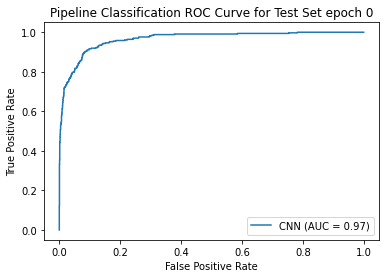

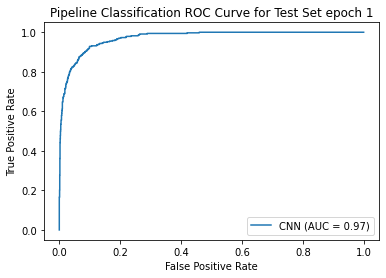

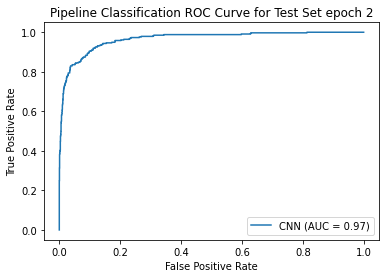

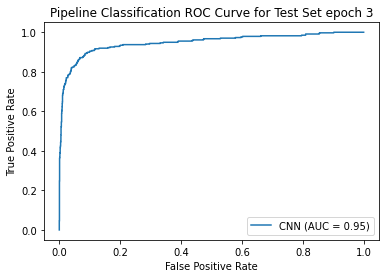

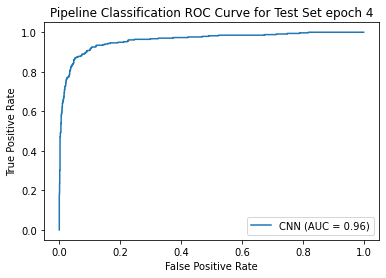

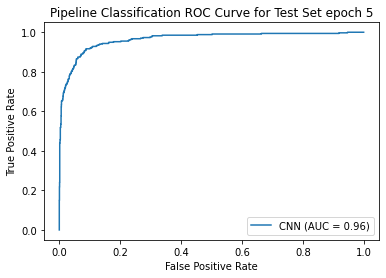

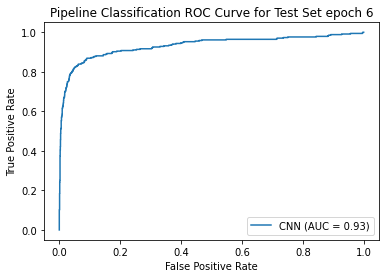

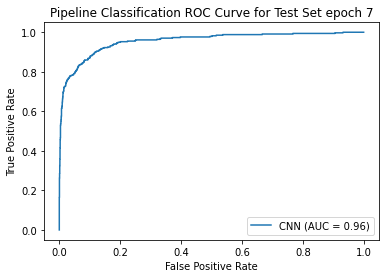

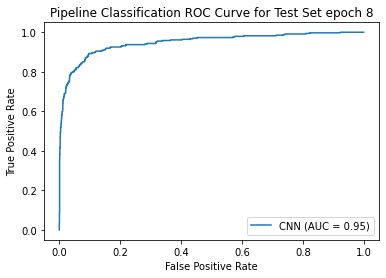

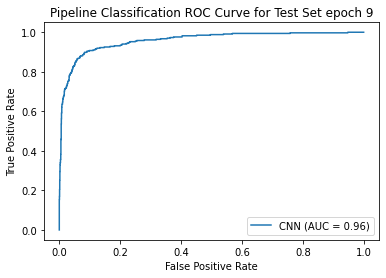

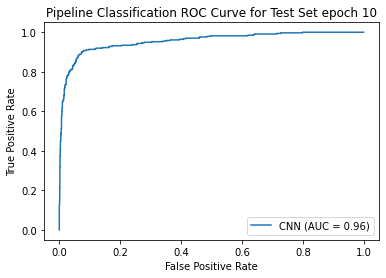

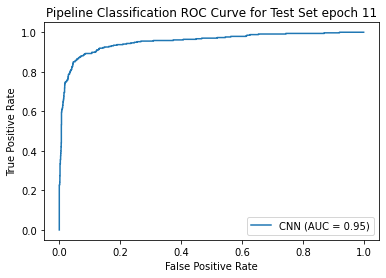

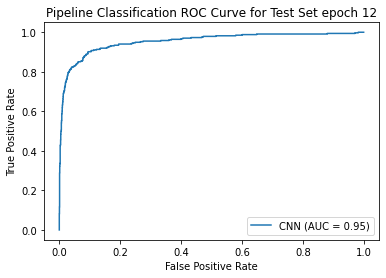

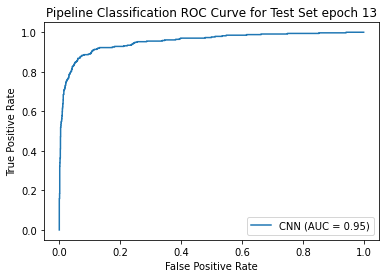

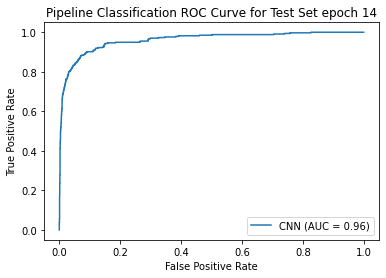

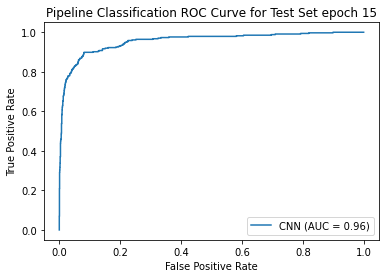

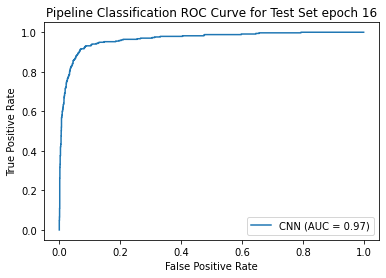

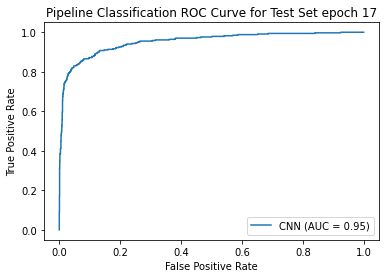

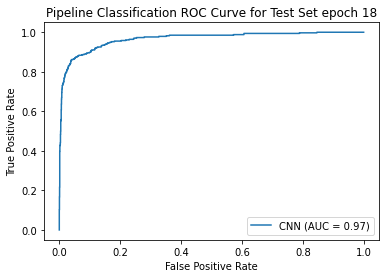

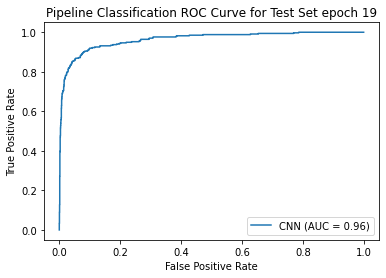

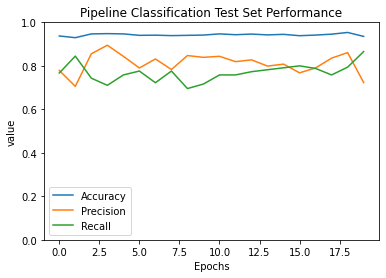

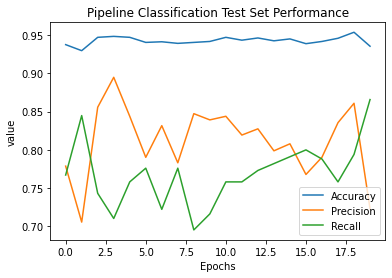

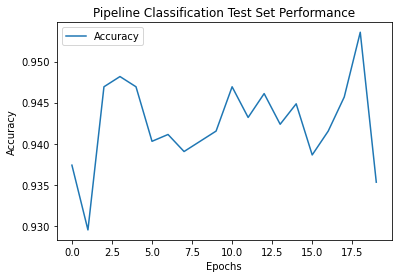

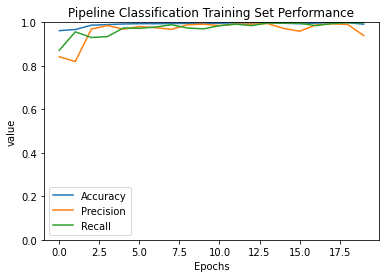

In [44]:
# main model

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
torch.manual_seed(16) # set seed for repeatable experiement
import torchvision
from sklearn import metrics
from PIL import ImageOps 
import time
start_time = time.time()
import matplotlib.pyplot as plt
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
learning_rate = 1e-4
batch_size = 32
num_epochs = 20
split_ratio = [0.7, 0.3]

# Image Resize parameter
size = (300,300) # resize to square
interpolation = InterpolationMode.BILINEAR
# Image Normalization parameter
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Load Data
dataset = CustomDataset(transform=transform)
#Path for model
model_name = dataset.classification +' model dict'
model_extension = '.pt'
timestr = time.strftime("%Y%m%d-%H%M%S")
trial_path = os.path.join(dataset.root_dir,'Trials',timestr +' '+ model_name)
if not os.path.exists(trial_path):
    os.mkdir(trial_path)
model_path = os.path.join(trial_path, timestr +' ' + model_name + model_extension)

# Paths for confusion matrix csv file for training and test set
filename_train = 'confusion matrix for training set'
filename_test = 'confusion matrix for testing set'
csv_extension = '.csv'
confusion_matrix_csv_training_path = os.path.join(trial_path,timestr +' ' + filename_train + csv_extension)
confusion_matrix_csv_testing_path = os.path.join(trial_path,timestr +' ' + filename_test + csv_extension)

#Paths for wrong prediction images
filename_train_wrong_index = 'wrong index for training set'
filename_test_wrong_index = 'wrong index for test set'

#Paths for all predictions
filename_train_all_prediction = 'all prediction for training set'
filename_test_all_prediction = 'all prediction for testing set'

# Define Transformation
#https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/4

class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        # use ImageOps to add padding because the file is in PIL format. Torch functional pad only works on tensor
        return ImageOps.expand(image, padding)
#https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4
transform = transforms.Compose(
                            # pad to square
                            [SquarePad(),
                             transforms.RandomRotation(degrees=(-1,1)),
                             transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                             transforms.RandomResizedCrop(size, scale=(0.5, 1.0), interpolation=interpolation),
                             transforms.RandomHorizontalFlip(p=0.1),
                             transforms.RandomPerspective(distortion_scale=0.1,p=0.1),
                             transforms.ToTensor(),
                             # Normalize using parameters from https://pytorch.org/docs/stable/torchvision/models.html
                             transforms.Normalize(mean=mean, std=std)])
                             # Always put random Erasing last because normalize can't functions without data.
                             #transforms.RandomErasing(p=0.1))



# split data into 70% training 30% test
data_split = [int(round(len(dataset) * split_ratio[0])), int(round(len(dataset) * split_ratio[1]))]
train_set, test_set = torch.utils.data.random_split(dataset,data_split,generator=torch.Generator().manual_seed(16))
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=4)
# Model
# change model to 1 label
model = torchvision.models.googlenet(pretrained=True, progress=True) # output is B, 1000s
model.fc = nn.Linear(1024, 2) # change number of class to 2 in the final fully connected layer

model.to(device) # use gpu for faster training if available

#Loss and optimizer
criterion = nn.CrossEntropyLoss() # read the documentation!! also see binary entropyloss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define accuracy function here
# epochs, training accuracy, testing accuracy
# To do Train / test accuracy as a function of epochs to 20 epochs

# Create confusion matrix result container
confusion_matrix_training = pd.DataFrame(columns = ['True Positive', 'True Negative', 'False Positive', 'False Negative', 'Accuracy', 'Precision' , 'Recall', 'Specificity' , 'False Positive Rate'])
confusion_matrix_testing = pd.DataFrame(columns = ['True Positive', 'True Negative', 'False Positive', 'False Negative', 'Accuracy', 'Precision' , 'Recall', 'Specificity' , 'False Positive Rate'])


# Train Network
for epoch in range(num_epochs):
    losses = []
    print(f'working on epoch {epoch}')
    for batch_idx,(data, targets,_) in enumerate(train_loader):
        #print(f' training with batch no. {batch_idx}')
        # sent data to GPU
        data, targets = data.to(device), targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # adam step
        optimizer.step()

    print(f'Cost at epoch {epoch} is {sum(losses) / len(losses)}')
    # only get wrong images in the last epoch
    #if epoch == num_epochs - 1:
    #    get_index_wrong_prediction = True
    #else:
    #   get_index_wrong_prediction = False
    get_index_wrong_prediction = True
    # for each epoch, calculate confusion matrix and append the result to container
    print('evaluating training set')
    confusion_matrix_per_epoch_training, wrong_prediction_training, prob_training, all_y_training, all_prediction_training = check_model(train_loader, model,epoch, get_index_wrong_prediction)
    print('evaluating testing set')
    confusion_matrix_per_epoch_testing, wrong_prediction_testing, prob_testing, all_y_testing, all_prediction_testing = check_model(test_loader, model,epoch, get_index_wrong_prediction)
    confusion_matrix_training = confusion_matrix_training.append(confusion_matrix_per_epoch_training)
    confusion_matrix_testing = confusion_matrix_testing.append(confusion_matrix_per_epoch_testing)
    

    # save confusion matrix for each epoch and overwrite
    confusion_matrix_training.to_csv(path_or_buf=confusion_matrix_csv_training_path)
    confusion_matrix_testing.to_csv(path_or_buf=confusion_matrix_csv_testing_path)
    # The index column on confusion_matrix data frame is the number of epoch, rename index to epoch
    plot_ROC_curve(all_y_testing,prob_testing,epoch)

    # save model for each epoch
    #https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb
    #https://pytorch.org/tutorials/beginner/saving_loading_models.html
    model_path = os.path.join(trial_path, timestr +' ' + model_name + ' epoch ' + str(epoch) + model_extension)
    torch.save(model.state_dict(), model_path)

    #save all predictions for each epoch
    all_prediction_training_path = os.path.join(trial_path,timestr +' ' + filename_train_all_prediction + ' epoch ' + str(epoch) + csv_extension)
    wrong_index_test_path = os.path.join(trial_path,timestr +' ' + filename_test_all_prediction + ' epoch ' + str(epoch) + csv_extension)
    pd.DataFrame(all_prediction_training).applymap(int).to_csv(path_or_buf=all_prediction_training_path)
    pd.DataFrame(all_prediction_testing).applymap(int).to_csv(path_or_buf=wrong_index_test_path)

    #save index of inaccuracte predictions
    wrong_index_training_path = os.path.join(trial_path,timestr +' ' + filename_train_wrong_index + ' epoch ' + str(epoch) + csv_extension)
    wrong_index_test_path = os.path.join(trial_path,timestr +' ' + filename_test_wrong_index + ' epoch ' + str(epoch) + csv_extension)
    pd.DataFrame(wrong_prediction_training).applymap(int).to_csv(path_or_buf=wrong_index_training_path)
    pd.DataFrame(wrong_prediction_testing).applymap(int).to_csv(path_or_buf=wrong_index_test_path)

#Plot model performances

#Plot test set result with ylim (0,1)
confusion_matrix_testing.plot(y=['Accuracy', 'Precision', 'Recall'],title=dataset.classification.title() +' Classification Test Set Performance', xlabel ='Epochs', ylabel='value', legend = True, ylim = (0,1))
plt.savefig(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() +' Classification Test Set Performance'+ ' ylim (0,1) ' +'.png'))

#Plot test set result without ylim (0,1)
confusion_matrix_testing.plot(y=['Accuracy', 'Precision', 'Recall'],title=dataset.classification.title() +' Classification Test Set Performance', xlabel ='Epochs', ylabel='value', legend = True)
plt.savefig(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() +' Classification Test Set Performance' + '.png'))

#Plot test set accuracy without
confusion_matrix_testing.plot(y=['Accuracy'],
                              title=dataset.classification.title() +' Classification Test Set Performance',
                              xlabel='Epochs', 
                              ylabel='Accuracy')
plt.savefig(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() +' Classification Test Set Accuracy'+ '.png'))

#Plot training set result with ylim (0,1)
confusion_matrix_training.plot(y=['Accuracy', 'Precision', 'Recall'],title='Pipeline Classification Training Set Performance', xlabel ='Epochs', ylabel='value', legend = True, ylim = (0,1))
plt.savefig(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() +' Classification Training Set Performance'+ ' ylim (0,1) ' + '.png'))


end_time = time.time()
with open(os.path.join(trial_path, timestr + ' ' + dataset.classification.title() +' time' + '.txt'), 'a') as txt:
    txt.write(f'total time taken = {end_time - start_time}\n')



# Task:

'''
get the epoch vs accuracy in test set curve
training vs validation set curve to determine when the model over fit
compare the three models performance
look at failure cases
understand losses
what predicted value represents?

'''




In [ ]:
# load previous models parameters and  make predictions
from sklearn import metrics

dataset = CustomDataset(transform=transform)
model_name = dataset.classification +' model dict'
model_extension = '.pt'
timestr = "20210226-224012"
trial_path = os.path.join(dataset.root_dir,'Trials',timestr +' '+ model_name)

model_path = os.path.join(trial_path, timestr +' ' + model_name + model_extension)

model.load_state_dict(torch.load(model_path,map_location=device))
epoch = 19


confusion_matrix_per_epoch_testing, wrong_prediction_testing, prob_testing, all_y_testing = check_model(test_loader, model,epoch, False)


    


NameError: ignored

In [ ]:
# Check accuracy on training to see how good our model is
import torchvision.transforms.functional as TF
  
def getImageWrongPredictions(accurate_prediction, predictions, x, y, mean, std):
    '''
    This function get the images of incorrect prediction for diagonsis for one batch in dataloader
    accurate_prediction is a binary mask for correct prediction in a batch
    x is date tensor from data loader in the dimention of B,C,H,W
    y is the label in the dimention of B
    mean is the mean parameter used in image normalization
    std is the standard deviation parameter used in image normalization
    # comment in python doc string style, PEP 8
    '''
    # collect wrong prediction for analysis
    #https://discuss.pytorch.org/t/how-to-save-wrong-prediction-results-of-a-cnn-on-mnist/66576
    
    
    # create mask for incorrect prediction
    wrong_idx = ~accurate_prediction
    # get a list of image
    wrong_samples = x[wrong_idx]
    # create a list of incorrect prediction
    wrong_preds = predictions[wrong_idx]
    # create a list of true label
    actual_preds = y[wrong_idx]
    # create the unormalize object
    unorm = UnNormalize(mean=mean, std=std)
    # create an empty list to store images
    wrong_images = []
    for i in range(wrong_idx.sum()):
        # get image
        sample = wrong_samples[i]
        # unnormalize image
        unnormlized_img = unorm(sample).byte()
        # convert from tensor to image
        img = TF.to_pil_image(unnormlized_img)
        wrong_images.append(img)
        # label management
        wrong_pred = wrong_preds[i]
        actual_pred = actual_preds[i]  
    return wrong_images

# Image Normalization parameter
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

model.eval()
wrong_training_prediction_images = []
with torch.no_grad():
    for x,y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device) # B, 1
        scores = model(x) # B, 2s check with scores.size
        _, predictions = scores.max(1)
        accurate_prediction = (predictions == y)
        print("Checking accuracy on Training Set")
        wrong_training_prediction_images.extend(getImageWrongPredictions(accurate_prediction,predictions, x, y, mean, std))

        #print("Checking accuracy on Test Set")
        #wrong_testing_prediction_images = getImageWrongPredictions(test_loader,predictions, x, y, mean, std)


#doc string (PEP 8)
# comment about function type of parameters
# what the function is supposed to do




In [ ]:
#https://stackoverflow.com/questions/61368632/display-image-in-a-pil-format-from-torch-tensor
class UnNormalize(object):
    '''
    The UnNormalize object takes in a normalized tensor and transform to an unonrmalized tensor
    '''
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m) 
            # The normalize code -> t.sub_(m).div_(s)
        return tensor * 255


In [ ]:
import torchvision.transforms.functional as TF


#visualize failed cases

img = wrong_testing_prediction[21] 
#
#unnormlized_img = unorm(sample)
#unnormlized_img = unnormlized_img.byte()
#img = TF.to_pil_image(unnormlized_img)
img
#plot training accuracy vs testing accuracy to detect over fitting
# visualized failed prediction images to find patterns in the fail cases.
# plot ROC using sklearn
# Confusion matrix
# lower learning rate because the curve flucturate a lot

NameError: ignored

/content/drive/MyDrive/Pipeline Classification/Class_pipeline/pipeline-a03db429e49e7d3b1a271d2f5dbe4f536c5a24ce3f0eb544c813e908489685c1.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


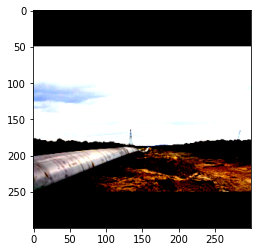

In [ ]:
from google.colab.patches import cv2_imshow

img_path = CustomDataset(transform=transform).annotations.iloc[4, 0]
print(img_path)
img = Image.open(img_path)
img.show()
image = transform(img)
plt.imshow(image.permute(1, 2, 0))
#CustomDataset(csv_path,root_dir,transform).

In [ ]:
# load and plot wrong predictions
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages
import re

# load dataset
transform_plot = transforms.Compose(
                        # pad to square
                        [SquarePad(),
                        transforms.Resize((800,800)),
                        ])
dataset = CustomDataset(transform=transform_plot)

#load wrong prediction
model_name = dataset.classification +' model dict'

timestr =  '20210226-224012'
trial_path = os.path.join(dataset.root_dir,'Trials',timestr +' '+ model_name)
csv_extension = '.csv'
filename_test_wrong_index = 'wrong index for test set'
wrong_index_test_path = os.path.join(trial_path,timestr +' ' + filename_test_wrong_index + csv_extension)
wrong_prediction = pd.read_csv(wrong_index_test_path,index_col=0)
wrong_prediction = wrong_prediction.to_dict(orient='list')

SaveWrongPredictions(dataset, wrong_prediction)




In [ ]:
# if the dataframe is contains literal tensor such as 'tensor(10)'
def GetNum(string):
    get_num = re.search('(\d+)',string).group(0)
    return int(get_num)
wrong_prediction.applymap(GetNum).to_csv(path_or_buf=wrong_index_test_path)


In [ ]:
print(prob)
prob.cpu().index_select(1,torch.tensor([1]))

tensor([[0.8380, 0.1403],
        [0.2987, 0.6578],
        [0.7458, 0.2339],
        [0.8464, 0.1173],
        [0.3379, 0.6116],
        [0.7948, 0.1689],
        [0.9032, 0.0827],
        [0.6810, 0.2911],
        [0.9452, 0.0347],
        [0.8462, 0.1352],
        [0.8471, 0.1299],
        [0.9276, 0.0516],
        [0.1794, 0.7849],
        [0.7934, 0.1764],
        [0.8991, 0.0707],
        [0.8831, 0.0788],
        [0.7551, 0.2076],
        [0.6761, 0.2639],
        [0.9306, 0.0569],
        [0.7613, 0.1980],
        [0.8388, 0.1291],
        [0.8984, 0.0754],
        [0.7501, 0.1864],
        [0.7295, 0.2047],
        [0.3284, 0.6296],
        [0.9090, 0.0731],
        [0.9155, 0.0609]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [19]:
 y = torch.rand((1,32)).to(device=device)

all_y = y.cpu().numpy().transpose()
#all_y = np.hstack((all_y,y.cpu().numpy()))

array([[0.89611584, 0.6720818 , 0.6936349 , 0.08048147, 0.28730172,
        0.3170569 , 0.3778352 , 0.03412145, 0.33186704, 0.48756737,
        0.04708081, 0.2828204 , 0.66891634, 0.26289046, 0.927531  ,
        0.42008096, 0.29884917, 0.13344109, 0.4948135 , 0.15708923,
        0.10839635, 0.006033  , 0.19103307, 0.7018077 , 0.67055666,
        0.6075394 , 0.96991044, 0.8242113 , 0.09431779, 0.8338123 ,
        0.6709754 , 0.27027214, 0.89611584, 0.6720818 , 0.6936349 ,
        0.08048147, 0.28730172, 0.3170569 , 0.3778352 , 0.03412145,
        0.33186704, 0.48756737, 0.04708081, 0.2828204 , 0.66891634,
        0.26289046, 0.927531  , 0.42008096, 0.29884917, 0.13344109,
        0.4948135 , 0.15708923, 0.10839635, 0.006033  , 0.19103307,
        0.7018077 , 0.67055666, 0.6075394 , 0.96991044, 0.8242113 ,
        0.09431779, 0.8338123 , 0.6709754 , 0.27027214]], dtype=float32)